In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import os
import uproot
from scipy import interpolate
from scipy.optimize import curve_fit, fsolve

plt.style.use('physics.mplstyle')

In [2]:
f = uproot.open("../higgsCombineSUEP-m750-generic.AsymptoticLimits.mH125.root")
limit = f['limit']['limit'].array(library="np")
limit

array([0.00030518, 0.00110626, 0.00244141, 0.00503888, 0.00796103,
       0.00158625])

In [3]:
def get_limits(fn):
    f = uproot.open(fn)
    limit = f["limit"]['limit'].array(library="np")
    quant = f["limit"]['quantileExpected'].array(library="np")
    
    if limit.shape[0] == 1:
        return -1
    else:
        return np.stack([quant,limit])

def get_SUEP_file(Mass=125, mdark=2, t=1, decay="darkPho", path="./"):
    fname = os.path.join(
        "../higgsCombineSUEP-m{}-md{}-t{}-{}.AsymptoticLimits.mH125.root".format(Mass, mdark, t, decay)
    )
    #print (fname)
    if os.path.isfile(fname):
        return fname
    else:
        pass

In [4]:
temps = [0.5, 1, 2, 3, 4]
decay = "generic"
mass = 400
md = 2
for temp in temps:
    m = mass
    limit = get_limits(get_SUEP_file(Mass=m, mdark = md, t=temp, decay=decay))
    print("SUEP m-"+ str(m), "\t: ", 
             np.round(limit[1,2],5), "\t+/- [",
             np.round(limit[1,3],5), ",",
             np.round(limit[1,1],5), "]"
        )

SUEP m-400 	:  0.00439 	+/- [ 0.0094 , 0.00216 ]
SUEP m-400 	:  0.00439 	+/- [ 0.0094 , 0.00216 ]
SUEP m-400 	:  0.01123 	+/- [ 0.02446 , 0.00492 ]
SUEP m-400 	:  0.04541 	+/- [ 0.10019 , 0.02222 ]
SUEP m-400 	:  0.14844 	+/- [ 0.32751 , 0.08606 ]


In [5]:
xsec = {"125": 34.8, "400": 5.9, "750": 0.5, "1000": 0.17}

In [6]:
def log_interp1d(xx, yy, kind='linear'):
    logx = np.log(xx)
    logy = np.log(yy)
    lin_interp = interpolate.interp1d(logx, logy, bounds_error=False, fill_value="extrapolate", kind=kind)
    log_interp = lambda zz: np.power(np.e, lin_interp(np.log(zz)))
    return log_interp

In [23]:
def plot_dim_interpolate(decay="darkPho", unblind=True, quadratic=False):
    limits = []
    limitx = []
    #temps = [0.5, 1, 2, 3, 4]
    #temps = [1.5,3,6]
    temps = [1,5,10]
    decay = "generic"
    Mass = 400
    md = 5
    for temp in temps:
        try:
            limit = get_limits(get_SUEP_file(Mass=m, mdark = md, t=temp, decay=decay))*xsec[str(Mass)]

            if not isinstance(limit, int) and limit.shape == (2,6):
                limits.append(limit)
                limitx.append(temp)
        except:
            print(" failed : ", Mass, " : ", decay)
            pass
    limits = np.array(limits)
    limitx = np.array(limitx)
    
    _exp = np.array([l[1][2] for l in limits]) 
    _s1p = np.array([l[1][1] for l in limits]) 
    _s1m = np.array([l[1][3] for l in limits]) 
    _s2p = np.array([l[1][0] for l in limits]) 
    _s2m = np.array([l[1][4] for l in limits])
    _obs = np.array([l[1][5] for l in limits])
    
    print(_exp)
    print(_s2p)
    print(_s2m)
    print(limitx)
    
    if quadratic:
        exp_limit = interpolate.interp1d(limitx, _exp, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s1p_limit = interpolate.interp1d(limitx, _s1p, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s1m_limit = interpolate.interp1d(limitx, _s1m, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s2p_limit = interpolate.interp1d(limitx, _s2p, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s2m_limit = interpolate.interp1d(limitx, _s2m, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        obs_limit = interpolate.interp1d(limitx, _obs, bounds_error=False, fill_value="extrapolate", kind="quadratic")
    else:
        #exp_limit = interpolate.interp1d(limitx, _exp, bounds_error=False, fill_value="extrapolate", kind="linear")
        #s1p_limit = interpolate.interp1d(limitx, _s1p, bounds_error=False, fill_value="extrapolate", kind="linear")
        #s1m_limit = interpolate.interp1d(limitx, _s1m, bounds_error=False, fill_value="extrapolate", kind="linear")
        #s2p_limit = interpolate.interp1d(limitx, _s2p, bounds_error=False, fill_value="extrapolate", kind="linear")
        #s2m_limit = interpolate.interp1d(limitx, _s2m, bounds_error=False, fill_value="extrapolate", kind="linear")
        #obs_limit = interpolate.interp1d(limitx, _obs, bounds_error=False, fill_value="extrapolate", kind="linear")
        exp_limit = log_interp1d(limitx, _exp)
        s1p_limit = log_interp1d(limitx, _s1p)
        s1m_limit = log_interp1d(limitx, _s1m)
        s2p_limit = log_interp1d(limitx, _s2p)
        s2m_limit = log_interp1d(limitx, _s2m)
        obs_limit = log_interp1d(limitx, _obs)
    print(exp_limit)
    plt.figure(figsize=(6,6))
    ax = plt.gca()
    
    plt.plot(limitx, _exp,'.', ms=12, color='black')
    #xvar = np.linspace(0,5,5)
    xvar = np.array(temps)
    plt.plot(xvar, exp_limit(xvar), ls="--", ms=12, color='black', label="Median expected")
    
    plt.fill_between(xvar, s2m_limit(xvar), s2p_limit(xvar), color="#FFCC01", lw=0, label="Expected $\pm 2\sigma$")
    plt.fill_between(xvar, s1m_limit(xvar), s1p_limit(xvar), color="#00CC00", lw=0, label="Expected $\pm 1\sigma$")

    #Observed limit
    #plt.plot(limitx, _obs,'.', ms=12, color='black')
    #plt.plot(xvar, obs_limit(xvar), ls="-", ms=12, color='black', label="Median Observed")
    
    #Theoretical cross section
    plt.plot((0,1100), 
             (5.9, 5.9), #*.101,#* 0.101* 2/3, 
             "--", ms=12, color='blue', label="$\sigma_{theory}$ (pb)")
    
    #plt.ylabel(r"$\sigma(SUEP)$ (fb)")
    #plt.ylabel(r"$\mu(\frac{\sigma_{obs}}{\sigma_{theo}})$")
    plt.ylabel(r"$\sigma_{obs}$ (pb)")
    plt.xlabel(r"$Temp$ (GeV)")
    plt.legend(loc="upper left", fontsize=14)
    cms = plt.text(
        0., 1., u"CMS $\it{preliminary}$",
        fontsize=16, fontweight='bold',
        horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        1., 1., r"%.1f fb$^{-1}$ (13 TeV)" % 60.0,
        fontsize=14, horizontalalignment='right', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    info = plt.text(
        0.6, 0.8, r"$M_{SUEP}$ = 400 GeV""\n""$M_{d}$ = 2 GeV""\n""generic",
        fontsize=14, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)
    plt.xlim([0, 11])
    plt.ylim(1e-3,4e5)
    plt.yscale("log")
    plt.savefig("plots/SUEP_limits_m{}_md{}_{}_{}.pdf".format(Mass, md, temp, decay))
    plt.savefig("plots/SUEP_limits_m{}_md{}_{}_{}.png".format(Mass, md, temp, decay))
    
    plt.show()

decay :  generic
[5.47363281e-02 7.08000000e+01 1.16348000e+04]
[1.53945923e-02 1.41046875e+01 5.09022500e+03]
[1.85700808e-01 2.42295578e+02 3.98051509e+04]
[ 1  5 10]
<function log_interp1d.<locals>.<lambda> at 0x7f2ede01bca0>


/tmp/ipykernel_2115385/838681307.py:102: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)


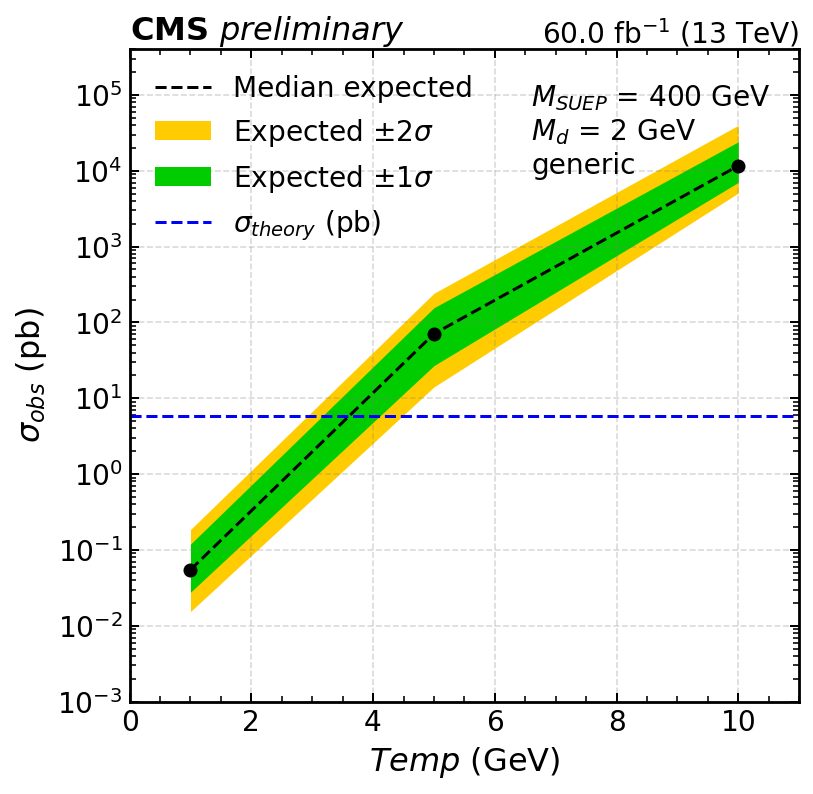

In [24]:
for decay in ["generic"]:
    print("decay : ", decay)
    plot_dim_interpolate(decay=decay, unblind=False, quadratic=False)